In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\shudd\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\shudd\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\shudd\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\shudd\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\shudd\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\shudd\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

In [62]:
class SHM_PINN(nn.Module):
    def __init__(self, activation="tanh"):
        super().__init__()

        if activation == "tanh":
            act = nn.Tanh()
        elif activation == "sigmoid":
            act = nn.Sigmoid()
        else:
            raise ValueError("activation must be 'tanh' or 'sigmoid'")

        self.net = nn.Sequential(
            nn.Linear(1, 32),
            act,
            nn.Linear(32, 32),
            act,
            nn.Linear(32, 1)
        )

    def forward(self, t):
        return self.net(t)


In [47]:
A=5.0
T_final = 5.0
X_collocation = 200
w=1.0
# small number of anchor points
t_data = torch.tensor([[0.0], [np.pi/2], [np.pi]], dtype=torch.float32)
x_data = torch.sin(w * t_data)

In [48]:
def physics_residual(model, t):
   x_hat=model(t)
   dx_dt = torch.autograd.grad(x_hat, t,grad_outputs=torch.ones_like(x_hat),create_graph=True)[0]
   d2x_dt2 = autograd.grad(dx_dt, t, grad_outputs=torch.ones_like(dx_dt), create_graph=True)[0]
   residual= d2x_dt2 + w**2 * x_hat
   return residual

In [52]:
def data_assisted_loss(model, t_data, x_data, lambda_data=10.0):
    # physics loss
    t_col = torch.rand(200, 1) * 2*np.pi
    t_col.requires_grad_(True)

    res = physics_residual(model, t_col)
    physics_loss = torch.mean(res**2)

    # data loss (few anchor points)
    data_loss = torch.mean((model(t_data) - x_data)**2)

    return physics_loss + lambda_data * data_loss

In [65]:
def train(model, loss_fn, epochs=5000):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model)
        loss.backward()
        optimizer.step()

    return model


In [72]:
model_Tanh = SHM_PINN('tanh')
train(model_Tanh,
      lambda m :data_assisted_loss(m, t_data, x_data))


SHM_PINN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [75]:
model_sigmoid = SHM_PINN("sigmoid")
train(
    model_sigmoid,
    lambda m: data_assisted_loss(m, t_data, x_data),
)


SHM_PINN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

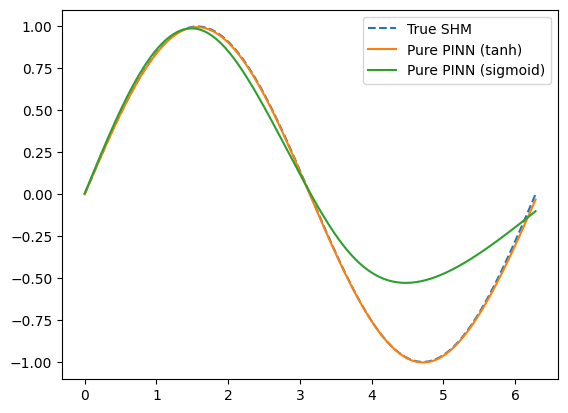

In [76]:
import matplotlib.pyplot as plt

t_test = torch.linspace(0, 2*np.pi, 400).view(-1,1)
x_true = torch.sin(t_test)

plt.plot(t_test, x_true, "--", label="True SHM")
plt.plot(t_test, model(t_test).detach(), label="Pure PINN (tanh)")
plt.plot(t_test, model_sigmoid(t_test).detach(), label="Pure PINN (sigmoid)")

plt.legend()
plt.show()
